In [1]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [3]:
model_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\model_vars_data_n.csv',index_col=0)

test_vars_data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\test_vars_data_n.csv',index_col=0)

price_train = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_train.csv',index_col=0)

price_test = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\Data Science Bootcamp August\Machine Learning Project\data\ny_test.csv',index_col=0)

In [4]:
# list(model_vars_data.columns) 
model_vars_data = model_vars_data.drop(['MoSold','MSSubClass','LotArea'], axis = 1)
test_vars_data = test_vars_data.drop(['MoSold','MSSubClass','LotArea'], axis = 1) 
#there is a transformed version of LotArea


In [5]:
# Fucntion returns dictionary

def regx3(
model=  None,
x_train = None,
x_test = None,
y_train = None,
y_test =  None,
params = None,
cv_ = 5,
linear_reg = True,
tree_based = False):
######################################
#########################################

    features = list(x_train.columns)

    ss = StandardScaler()
    x_train = pd.DataFrame(ss.fit_transform(x_train), columns = features)
    x_test = pd.DataFrame(ss.fit_transform(x_test), columns = features)

    #     print('train ',x_train.head())
    #     print(' ')
    #     print('test ', x_test.head())


    gs = GridSearchCV(model, params, cv=cv_, return_train_score=True, refit=True)
    gs.fit(x_train,y_train)
    gs.best_params_

    reg_dict = {}
    model= gs.best_estimator_
    reg_dict['mod'] = model
    ###################################    

    print('best params: ',gs.best_params_)
    reg_dict['best params'] = gs.best_params_

    print('score: ',gs.score(x_train,y_train))
    reg_dict['score'] = gs.score(x_train,y_train)

    print('  ')
    print('test score: ',gs.score(x_test,y_test))
    reg_dict['test score'] = gs.score(x_test,y_test)

    if linear_reg:
        adj_r2 = 1-(1-gs.score(x_train,y_train))*(x_train.shape[0] - 1) / (x_train.shape[0] - x_train.shape[1] - 1)
        print('adj_r2: ', adj_r2)
        reg_dict['adj_r2'] = adj_r2

        adj_r2_test = 1-(1-gs.score(x_test,y_test))*(x_test.shape[0] - 1) / (x_test.shape[0] - x_test.shape[1] - 1)
        print('  ')
        print('adj_r2_test: ',adj_r2_test)
        reg_dict['adj_r2_test'] = adj_r2_test

        print(' ')

    train_pred = gs.best_estimator_.predict(x_train)
    print('train RMSE: ' + str(mean_squared_error(train_pred,y_train)**0.5))
    print('  ')
    reg_dict['train RMSE'] = mean_squared_error(train_pred,y_train)**0.5

    test_pred = gs.best_estimator_.predict(x_test)
    print('test RMSE: ' + str(mean_squared_error(test_pred,y_test)**0.5))
    ###
    reg_dict['test RMSE'] = mean_squared_error(test_pred,y_test)**0.5

    if linear_reg:

        coefs = pd.Series(gs.best_estimator_.coef_, name = 'coef' )

        varnames = pd.Series(features, name = 'features')

        pd.set_option('display.max_rows', None) # or 1000.

        abs_coefs = pd.Series(np.abs(coefs),name = 'abs_val')

        coefs_ = pd.concat([varnames,coefs, abs_coefs], axis=1)

        #return:
        model_importances = coefs_.sort_values(by=['abs_val'], ascending=False)
        model_importances.index=(range(model_importances.shape[0]))
        model_importances
        reg_dict['model_importances'] = model_importances

        print(model_importances)
        print(' ')

    elif tree_based:
        pd.set_option('display.max_rows', None) # or 1000.

        #return
        varnames = pd.Series(features, name = 'features')

        importances_ = pd.Series(model.feature_importances_, name = 'importances')

        df = pd.concat([varnames,importances_], axis=1)

        model_importances = df.sort_values(by=['importances'], ascending=False)

        model_importances.index=(range(model_importances.shape[0]))

        reg_dict['model_importances'] = model_importances



    #         model_importances = pd.Series(model.feature_importances_, index = features).sort_values(ascending=False)

        print(model_importances)


    if linear_reg:
        residuals = y_train - train_pred
        print('skewness: ',stats.skew(residuals))
        print(' ')
        sns.set_theme(style='darkgrid')
        sns.histplot(residuals, bins=20);

    print('model_importances.shape: ',model_importances.shape)
    
    return reg_dict


In [6]:
def to_keep(mod, amt):
    mod = mod['model_importances']
    keeps1 = mod.loc[mod['abs_val'] > amt,['features']]
    list_keeps1 = list(keeps1.features)
    return list_keeps1


remove due to mulicollinearity - see Correlations Analysis notebook

In [7]:
remove = ['log_first_FlrSF','BsmtFinSF1', 'BsmtUnfSF','yeo_GarageArea','GarageCars',
          'yeo_LotFrontage', 'BsmtFinSF2' ] #remove due to mulicollinearity #drop GarageYrBlt
#see Correlations Analysis notebook

In [8]:
keeps_set = set(model_vars_data.columns) - set(remove)
keeps_set
keeps = list(keeps_set)

best params:  {'alpha': 0.001, 'tol': 0.02}
score:  0.9452796979693885
  
test score:  0.926030646657569
adj_r2:  0.9383662043458115
  
adj_r2_test:  0.8998003795148629
 
train RMSE: 0.08829798229866237
  
test RMSE: 0.10136341761275722
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.150284  0.150284
1                                          OverallQual  0.065959  0.065959
2                                           house_age_ -0.060492  0.060492
3                                          OverallCond  0.049438  0.049438
4                                           bc_LotArea  0.040386  0.040386
5                                      yeo_TotalBsmtSF  0.034760  0.034760
6                                          MSZoning_RM -0.030578  0.030578
7                                  Exterior2nd_VinylSd  0.029918  0.029918
8                                  Exterior1st_VinylSd -0.029469  0.029469
9         Nei

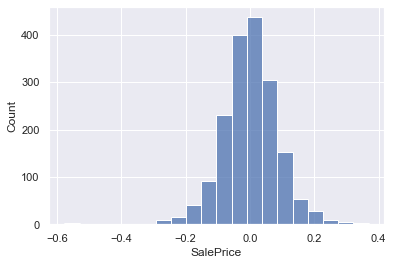

In [9]:
lasso1 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [10]:
keeps = to_keep(lasso1, 0.0002)

best params:  {'alpha': 0.001, 'tol': 0.02}
score:  0.9456290818036229
  
test score:  0.9254633277681327
adj_r2:  0.9408160273845297
  
adj_r2_test:  0.90800320260881
 
train RMSE: 0.08801564386403912
  
test RMSE: 0.1017513859957935
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.127294  0.127294
1                                          OverallQual  0.059416  0.059416
2                                           house_age_ -0.051349  0.051349
3                                      yeo_TotalBsmtSF  0.051254  0.051254
4                                          OverallCond  0.047578  0.047578
5                                           bc_LotArea  0.039876  0.039876
6         Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.025564  0.025564
7                                             2ndFlrSF  0.023323  0.023323
8                                         BsmtFullBath  0.021736  0.021736
9              

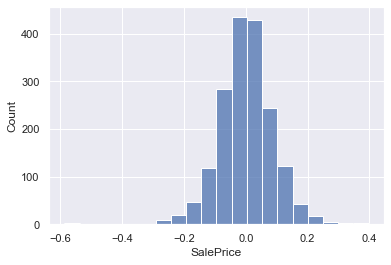

In [11]:
lasso2 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [12]:
keeps = to_keep(lasso2, 0.0002)

best params:  {'alpha': 0.001, 'tol': 0.02}
score:  0.9456535421562597
  
test score:  0.925456011396981
adj_r2:  0.9416266660630187
  
adj_r2_test:  0.9111519387009258
 
train RMSE: 0.08799584342707785
  
test RMSE: 0.10175637972985284
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.131739  0.131739
1                                          OverallQual  0.060301  0.060301
2                                           house_age_ -0.054743  0.054743
3                                      yeo_TotalBsmtSF  0.049421  0.049421
4                                          OverallCond  0.048307  0.048307
5                                           bc_LotArea  0.039469  0.039469
6         Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.025230  0.025230
7                                          MSZoning_RM -0.022198  0.022198
8                                         BsmtFullBath  0.021420  0.021420
9            

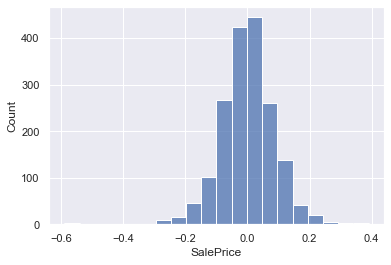

In [13]:
lasso3 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [14]:
keeps = to_keep(lasso3, 0.0005)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9470997124261662
  
test score:  0.9235213451536924
adj_r2:  0.9433506229764891
  
adj_r2_test:  0.9095515599031285
 
train RMSE: 0.08681715565273611
  
test RMSE: 0.10306838103084522
                                              features      coef   abs_val
0                                         bc_GrLivArea  0.130748  0.130748
1                                          OverallQual  0.061714  0.061714
2                                           house_age_ -0.053257  0.053257
3                                      yeo_TotalBsmtSF  0.049681  0.049681
4                                          OverallCond  0.048849  0.048849
5                                           bc_LotArea  0.040785  0.040785
6                                          MSZoning_RM -0.031231  0.031231
7                                             2ndFlrSF  0.029638  0.029638
8                                      Condition1_Norm  0.027041  0.027041
9           

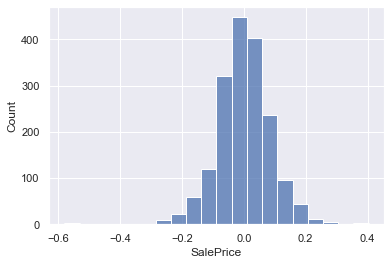

In [15]:
lasso4 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [16]:
features4 = to_keep(lasso4,0)
dummies=[]
for f in features4:
    if model_vars_data[f].max() == 1:
        dummies.append(f)


dummy_drops = []
for feature in dummies:
    if round(model_vars_data[feature].mean(),2) < 0.05:
        dummy_drops.append(feature)
dummy_drops

['Exterior1st_BrkFace',
 'SaleCondition_Partial',
 'Condition1_PosN',
 'MSSubClass_85',
 'SaleCondition_Family',
 'MSZoning_RH',
 'MSSubClass_160',
 'Condition1_PosA',
 'LandContour_HLS',
 'Exterior2nd_CBlock',
 'MSSubClass_80',
 'HouseStyle_1.5Unf',
 'Exterior1st_CBlock',
 'Exterior2nd_PreCast',
 'RoofStyle_Mansard',
 'Condition1_RRAn',
 'Condition2_Feedr',
 'Exterior2nd_Brk Cmn',
 'RoofMatl_WdShngl',
 'BldgType_Twnhs',
 'Exterior2nd_BrkFace',
 'HouseStyle_2.5Unf',
 'LotConfig_FR2',
 'Neighborhood_SawyerW',
 'MSSubClass_150',
 'Condition2_PosA',
 'Condition1_RRNn',
 'Foundation_Stone',
 'MSSubClass_30',
 'RoofStyle_Gambrel',
 'RoofMatl_Membran',
 'Heating_Grav',
 'Heating_OthW',
 'has_pool',
 'LotConfig_FR3',
 'Foundation_Wood',
 'Heating_Wall',
 'Electrical_FuseF',
 'Exterior2nd_AsphShn',
 'Condition2_RRNn',
 'Condition2_RRAn',
 'PavedDrive_P',
 'Exterior1st_AsphShn',
 'GarageType_Basment',
 'MSSubClass_40',
 'MoSold_11',
 'LandContour_Low',
 'RoofMatl_Tar&Grv',
 'MSSubClass_180']

In [17]:
keep_set = set(features4) - set(dummy_drops)
keeps = list(keep_set)
# keeps

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9368932373273804
  
test score:  0.9232782650588939
adj_r2:  0.9343527667180392
  
adj_r2_test:  0.9156612870575467
 
train RMSE: 0.09482317384600927
  
test RMSE: 0.10323204758344497
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.125760  0.125760
1                                         OverallQual  0.062920  0.062920
2                                     yeo_TotalBsmtSF  0.056389  0.056389
3                                         OverallCond  0.051011  0.051011
4                                          bc_LotArea  0.047641  0.047641
5                                          house_age_ -0.043576  0.043576
6        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.026364  0.026364
7                                         MSZoning_RM -0.024397  0.024397
8                                        BsmtFullBath  0.023181  0.023181
9                     

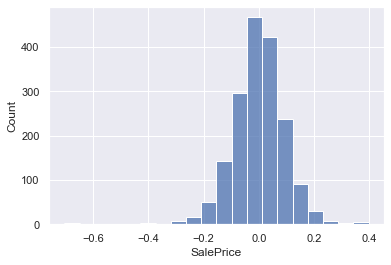

In [18]:
lasso5 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [19]:
combine = pd.concat([price_train, model_vars_data], axis=1)
combine["log_price"] = np.log(combine.SalePrice)
combine.head(3)

,SalePrice,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,...,Neighborhood_NAmes_SWISU_Sawyer,Neighborhood_BrkSide_Edwards_Blueste_OldTown_IDOTRR,has_wood_deck,has_openporch,has_EnclosedPorch,house_age_,years_since_remodeled_,has_basement,has_finsished_basement,log_price
1232,162900,4,3,7,5,3,3,4,3,0,...,False,False,False,True,False,30,30,True,False,12.000892
2381,133000,4,3,5,7,4,3,3,3,0,...,True,False,False,True,False,60,59,True,False,11.798104
810,189000,4,3,7,5,3,3,4,3,0,...,False,False,True,True,False,13,12,True,False,12.149502


In [20]:
features5 = to_keep(lasso5,0)
set5 = set(features5)
set5.add('log_price')
set5

list5 = list(set5)
type(list5)
combine[list5]

,MSZoning_RL,alley_access,bc_GrLivArea,GarageCond,TotRmsAbvGrd,OverallQual,MasVnrType_Stone,FullBath,PavedDrive_Y,MSSubClass_20,...,ScreenPorch,Condition1_Norm,Fence_MnPrv,has_basement,log_WoodDeckSF,Exterior2nd_Plywood,Functional,HeatingQC,MSSubClass_50,Exterior1st_Plywood
1232,1,False,8.907847,3,8,7,0,2,1,0,...,259,1,0,True,0.000000,0,8,3,0,0
2381,1,False,8.522448,3,6,5,0,1,1,0,...,0,1,0,True,0.000000,0,8,4,0,0
810,1,False,8.876645,3,7,7,0,2,1,0,...,0,1,0,True,3.891820,0,8,4,0,0
863,1,False,9.354421,3,9,8,0,2,1,0,...,0,1,0,True,4.890349,0,8,5,0,0
1346,0,False,8.742979,3,7,7,0,1,1,0,...,0,0,0,True,0.000000,0,8,5,0,0
367,0,False,8.907847,3,7,6,0,2,1,0,...,0,0,0,True,0.000000,0,8,5,1,0
377,0,False,8.351863,3,4,4,0,1,0,0,...,0,1,1,True,0.000000,0,8,4,1,0
316,1,False,8.525778,3,7,5,0,2,1,0,...,0,1,0,True,0.000000,0,8,3,1,0
1212,1,False,8.968368,3,7,9,1,2,1,1,...,0,1,0,True,5.768321,0,8,5,0,0
1751,0,False,7.852861,0,5,5,0,1,1,0,...,0,1,0,True,0.000000,0,8,4,0,0


In [21]:
pd.set_option('display.max_rows', None)


print("look at correlations with target")
df4a = combine[list5]
type(df4a)
corr = df4a.corr()
corr.sort_values(["log_price"], ascending = False, inplace = True)


# # type(corr.SalePrice)
# # # type(corr)
print(corr.log_price)
# type(combine)

look at correlations with target
log_price                                              1.000000
OverallQual                                            0.812202
bc_GrLivArea                                           0.731467
ExterQual                                              0.681508
KitchenQual                                            0.658549
yeo_TotalBsmtSF                                        0.641523
BsmtQual                                               0.619573
GarageYrBlt                                            0.591040
FullBath                                               0.567860
FireplaceQu                                            0.551453
Foundation_PConc                                       0.542354
Neighborhood_NoRidge_NridgHt_Veenker_StoneBr           0.516683
Fireplaces                                             0.505697
TotRmsAbvGrd                                           0.496065
HeatingQC                                              0.479445
log_Ope

In [22]:
drops =[ 'OverallCond',
'BldgType_TwnhsE',
'3SsnPorch',
'MSSubClass_70',
'has_finsished_basement'
'BsmtHalfBath',
'MoSold_7',
'LowQualFinSF',
'HouseStyle_1Story',
'Exterior2nd_Plywood',
'MoSold_3',
'MoSold_6',
'MoSold_9',
'Exterior1st_Plywood']

keeps_set = set(to_keep(lasso5,0)) - set(drops)
keeps_set
keeps = list(keeps_set)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9267239340600786
  
test score:  0.9156438079895916
adj_r2:  0.924260159089345
  
adj_r2_test:  0.9087136958980849
 
train RMSE: 0.1021780497388699
  
test RMSE: 0.1082464886270926
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.119932  0.119932
1                                         OverallQual  0.072778  0.072778
2                                     yeo_TotalBsmtSF  0.053037  0.053037
3                                          bc_LotArea  0.046696  0.046696
4        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.028077  0.028077
5                                          Functional  0.027524  0.027524
6                              years_since_remodeled_ -0.026697  0.026697
7                                         MSZoning_RM -0.024709  0.024709
8                                            2ndFlrSF  0.022752  0.022752
9                        

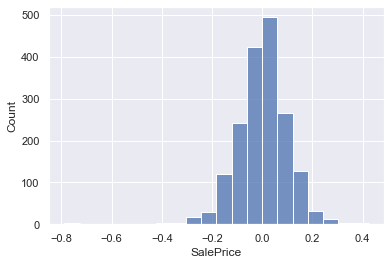

In [23]:
lasso6 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [24]:

keeps = to_keep(lasso6,0.004)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9263591933277376
  
test score:  0.9155447672541894
adj_r2:  0.9245393343122736
  
adj_r2_test:  0.9105079087131771
 
train RMSE: 0.10243203604487032
  
test RMSE: 0.10831001488795107
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.118805  0.118805
1                                    OverallQual  0.073375  0.073375
2                                yeo_TotalBsmtSF  0.052627  0.052627
3                                     bc_LotArea  0.046561  0.046561
4                                     Functional  0.027699  0.027699
5   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027094  0.027094
6                         years_since_remodeled_ -0.026992  0.026992
7                                    MSZoning_RM -0.025501  0.025501
8                                     Fireplaces  0.024867  0.024867
9                                       2ndFlrSF  0.024496  0.024496
10 

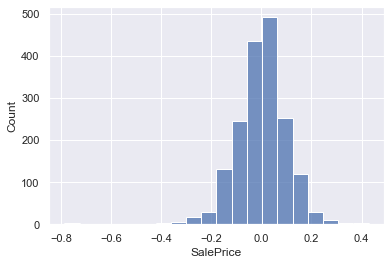

In [25]:
lasso7 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)
 
 

In [26]:
model_vars_data.GarageYrBlt.corr(model_vars_data['house_age_'])

-0.8495290774467831

In [27]:
keeps_set = set(to_keep(lasso7,0.0)) - set(['GarageYrBlt'])
keeps = list(keeps_set)

best params:  {'alpha': 1e-10, 'tol': 0.02}
score:  0.9261621657960152
  
test score:  0.9154893215064318
adj_r2:  0.9243808969639834
  
adj_r2_test:  0.9105731878544514
 
train RMSE: 0.10256897404755941
  
test RMSE: 0.10834556238603242
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.118032  0.118032
1                                    OverallQual  0.073632  0.073632
2                                yeo_TotalBsmtSF  0.052709  0.052709
3                                     bc_LotArea  0.046377  0.046377
4                         years_since_remodeled_ -0.027937  0.027937
5                                     Functional  0.027801  0.027801
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027218  0.027218
7                                    MSZoning_RM -0.025859  0.025859
8                                       2ndFlrSF  0.024977  0.024977
9                                   has_basement -0.024633  0.024633
10 

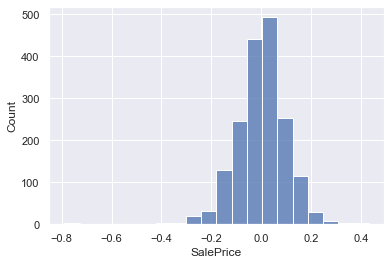

In [28]:
lasso8 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)
 
 

In [29]:
model_vars_data.GarageYrBlt.corr(model_vars_data['house_age_'])

-0.8495290774467831

In [30]:
model_vars_data.GarageYrBlt.corr(model_vars_data['house_age_'])

-0.8495290774467831

In [31]:
# OverallQual  OverallCond  
model_vars_data.OverallQual.corr(model_vars_data.OverallCond) 

-0.11280737059946867

In [32]:
#copy lasso 5 and drop GarageYrBlt since correlated with house age
keeps_set = set(to_keep(lasso5,0)) - set(['GarageYrBlt'])
keeps = list(keeps_set)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9366809639510605
  
test score:  0.9230036140466273
adj_r2:  0.9341703549415399
  
adj_r2_test:  0.9154809786373898
 
train RMSE: 0.09498251918576009
  
test RMSE: 0.10341665926580938
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.126559  0.126559
1                                         OverallQual  0.063169  0.063169
2                                     yeo_TotalBsmtSF  0.055652  0.055652
3                                          house_age_ -0.051290  0.051290
4                                         OverallCond  0.050649  0.050649
5                                          bc_LotArea  0.048051  0.048051
6        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.026282  0.026282
7                                         MSZoning_RM -0.023857  0.023857
8                                        BsmtFullBath  0.023090  0.023090
9                     

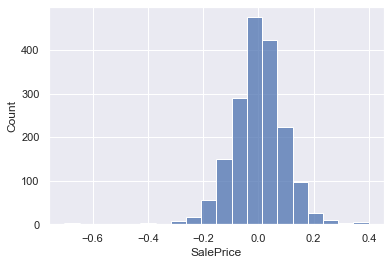

In [33]:
lasso9 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)
 

In [34]:
keeps= to_keep(lasso9,.002)

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9366296394720515
  
test score:  0.9231047538268004
adj_r2:  0.9344228944739801
  
adj_r2_test:  0.9165511817097662
 
train RMSE: 0.09502100635446495
  
test RMSE: 0.10334871467896814
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.126229  0.126229
1                                         OverallQual  0.062899  0.062899
2                                     yeo_TotalBsmtSF  0.055761  0.055761
3                                          house_age_ -0.050854  0.050854
4                                         OverallCond  0.050844  0.050844
5                                          bc_LotArea  0.047645  0.047645
6        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.026339  0.026339
7                                         MSZoning_RM -0.023526  0.023526
8                                        BsmtFullBath  0.023218  0.023218
9                     

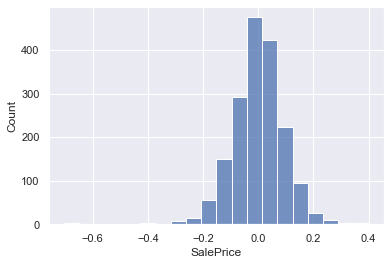

In [35]:
lasso10 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

# BEST MODEL lasso11

In [44]:
keeps = to_keep(lasso10,0.003)  
keeps_11 = ['bc_GrLivArea',
 'OverallQual',
 'yeo_TotalBsmtSF',
 'house_age_',
 'OverallCond',
 'bc_LotArea',
 'Neighborhood_NoRidge_NridgHt_Veenker_StoneBr',
 'MSZoning_RM',
 'BsmtFullBath',
 'has_basement',
 'BsmtExposure',
 '2ndFlrSF',
 'Functional',
 'Fireplaces',
 'BedroomAbvGr',
 'BsmtQual',
 'GarageCond',
 'KitchenQual',
 'Neighborhood_Somerst_Timber',
 'BsmtFinType1',
 'KitchenAbvGr',
 'HeatingQC',
 'Condition1_Norm',
 'TotRmsAbvGrd',
 'Neighborhood_ClearCr_CollgCr_Crawfor',
 'HouseStyle_1Story',
 'ExterQual',
 'ScreenPorch',
 'MSZoning_RL',
 'FullBath',
 'CentralAir_Y',
 'PavedDrive_Y',
 'BsmtHalfBath',
 'Neighborhood_Mitchel_NPkVill',
 'Foundation_PConc',
 'MasVnrType_Stone',
 'GarageFinish_RFn',
 'MSSubClass_20',
 'HalfBath',
 'FireplaceQu',
 'years_since_remodeled_',
 'MSSubClass_70',
 'Exterior1st_Plywood',
 'GarageType_Detchd',
 '3SsnPorch',
 'MSSubClass_50',
 'MoSold_7',
 'LowQualFinSF',
 'Electrical_SBrkr',
 'MoSold_3',
 'MoSold_9',
 'RoofStyle_Hip',
 'Exterior2nd_Plywood',
 'Neighborhood_BrkSide_Edwards_Blueste_OldTown_IDOTRR']

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.9364532430936179
  
test score:  0.9232044141313567
adj_r2:  0.9344685554863624
  
adj_r2_test:  0.9173636230934599
 
train RMSE: 0.09515316366997247
  
test RMSE: 0.10328172026567642
                                             features      coef   abs_val
0                                        bc_GrLivArea  0.127065  0.127065
1                                         OverallQual  0.063088  0.063088
2                                     yeo_TotalBsmtSF  0.055669  0.055669
3                                         OverallCond  0.051061  0.051061
4                                          house_age_ -0.049318  0.049318
5                                          bc_LotArea  0.047739  0.047739
6        Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.026436  0.026436
7                                         MSZoning_RM -0.023831  0.023831
8                                        has_basement -0.023577  0.023577
9                     

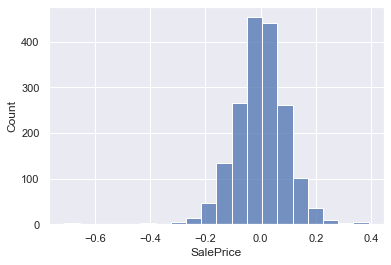

In [37]:
lasso11 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)

In [49]:
import math

features = list(model_vars_data[keeps].columns)
ss = StandardScaler()

x_train = pd.DataFrame(ss.fit_transform(model_vars_data[keeps_11]), columns = features)
x_test = pd.DataFrame(ss.fit_transform(test_vars_data[keeps_11]), columns = features)

predict_train = lasso11['mod'].predict(x_train).reshape((-1,1))
predict_test = lasso11['mod'].predict(x_test).reshape((-1,1))


predicted_price_test = pd.Series(list(map(math.exp,predict_test)), name = 'predicted_price_test')
predicted_price_train = pd.Series(list(map(math.exp,predict_train)), name = 'predicted_price_train')


In [56]:
price_compare_test = pd.concat([predicted_price_test,price_test.reset_index()], axis=1)

price_compare_test['price_difference'] =   price_compare_test['SalePrice'] - price_compare_test['predicted_price_test']


average difference test data

In [57]:
price_compare_test.price_difference.abs().mean()

13276.98391170696

In [58]:
price_compare_train = pd.concat([predicted_price_train,price_train.reset_index()], axis=1)

price_compare_train['price_difference'] =   price_compare_train['SalePrice'] - price_compare_train['predicted_price_train']


average difference train data

In [59]:
price_compare_train.price_difference.abs().mean()

12535.207517505007

In [43]:
keeps = to_keep(lasso11,0.004)
 

best params:  {'alpha': 1e-08, 'tol': 0.02}
score:  0.935794227004616
  
test score:  0.9234036849713471
adj_r2:  0.9340939014100347
  
adj_r2_test:  0.9184964001644974
 
train RMSE: 0.095645287331125
  
test RMSE: 0.1031476344110126
                                        features      coef   abs_val
0                                   bc_GrLivArea  0.125289  0.125289
1                                    OverallQual  0.063692  0.063692
2                                yeo_TotalBsmtSF  0.056915  0.056915
3                                    OverallCond  0.051554  0.051554
4                                     house_age_ -0.051457  0.051457
5                                     bc_LotArea  0.046998  0.046998
6   Neighborhood_NoRidge_NridgHt_Veenker_StoneBr  0.027166  0.027166
7                                    MSZoning_RM -0.024485  0.024485
8                                   has_basement -0.024123  0.024123
9                                   BsmtFullBath  0.023025  0.023025
10     

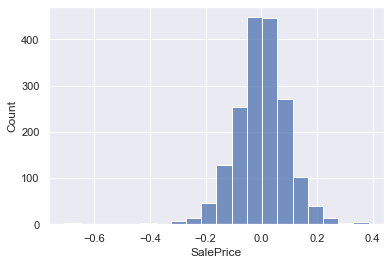

In [39]:
lasso12 = regx3(model= Lasso(max_iter=40000), #max_iter=10000000000000
x_train = model_vars_data[keeps],
x_test = test_vars_data[keeps],
y_train = np.log(price_train.SalePrice),
y_test = np.log(price_test.SalePrice),
params = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,100],'tol':[0.02]},
cv_ = 5,
linear_reg = True,
tree_based = False)